In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from pmdarima import auto_arima
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

# 1.Data Import

In [2]:
file_path = r'C:\Users\Dell\OneDrive\Desktop\atmoshpericemissionsghg.xlsx'
# Create an ExcelFile object to list available worksheets
xls = pd.ExcelFile(file_path)

In [3]:
# Get a list of worksheet names
sheet_names = xls.sheet_names

In [4]:
sheet_names

['Contents', 'GHG total ', 'CO2', 'CH4 ', 'N2O ', 'HFC', 'PFC', 'NF3', 'SF6']

In [5]:
# Initialize an empty dictionary to store separate DataFrames for each sheet
dfs = {}
# Read data from each worksheet and store it in the dictionary
for sheet_name in sheet_names:
    # Read data from the current sheet and store it as a DataFrame in the dictionary
    dfs[sheet_name] = pd.read_excel(xls, sheet_name=sheet_name)

In [6]:
# All sheet names
dfs.keys()

dict_keys(['Contents', 'GHG total ', 'CO2', 'CH4 ', 'N2O ', 'HFC', 'PFC', 'NF3', 'SF6'])

# 2.Data Cleaning

In [7]:
# Selecting the "GHG total " sheet from the DataFrame 'dfs'
# Reason: This sheet contains data related to greenhouse gas (GHG) emissions,
# which is essential for our analysis or reporting purposes. The other sheets
# may contain data for specific GHGs (e.g., CO2, CH4, N2O) or related information
# (e.g., HFC, PFC, NF3, SF6), but the "GHG total " sheet likely provides an
# overall summary or aggregate data for all greenhouse gases.
sheet1_data = dfs["GHG total "]

In [8]:
# Extracting relevant data and excluding unnecessary rows and columns
df = sheet1_data.iloc[2:26, 2:]

In [9]:
# Change the column names
df.columns = ['Year', 1990, 1991, 1992, 1993, 1994, 1995, 1996,1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
              2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020,2021]

In [10]:
# Drop rows with NaN values and reset index
df_cleaned = df.dropna().reset_index(drop=True)

In [11]:
# Set the first column as the index
df_cleaned.set_index("Year", inplace=True)

In [12]:
# Creating a new DataFrame 'df_new' by making a copy of 'df_cleaned'
df_new = df_cleaned.copy()

In [13]:
# Transposing 'df_new' to switch rows and columns
df_new = df_new.T

In [29]:
# Displaying the first 5 rows of the transposed DataFrame
df_new.head(5)

Year,"Agriculture, forestry and fishing",Mining and quarrying,Manufacturing,"Electricity, gas, steam and air conditioning supply","Water supply; sewerage, waste management and remediation activities",Construction,Wholesale and retail trade; repair of motor vehicles and motorcycles,Transport and storage,Accommodation and food services,Information and communication,...,"Professional, scientific and technical activities",Administrative and support service activities,Public administration and defence; compulsory social security,Education,Human health and social work activities,"Arts, entertainment and recreation",Other service activities,Activities of households as employers; undifferentiated goods and services-producing activities of households for own use,Consumer expenditure,Total greenhouse gas emissions
1990,55978.4,50762.1,176067.9,217638.6,75232.5,5786.8,12127,66667.4,3139.2,1199.4,...,2568.7,2934.8,12375.8,6393,6151.5,1797.7,1162.8,76.3,143893.7,842944.6
1991,55808.5,50877.2,177032.4,214348.2,76756.7,5946.2,12490.8,67119.0,3550.4,1272.6,...,2767.7,3060.6,11673.3,6714.7,6471.1,1885.4,1251.9,75.1,152359.2,852556.5
1992,55510.4,51480.6,170118.3,202484.4,76870.8,6058.3,12324.7,68163.3,3270.5,1241.8,...,2672.5,3024.1,11826.0,6845.3,6828.4,1712.9,1191.3,76.8,150676.4,833417.1
1993,54725.4,51092.0,165079.3,185006.1,77189.4,6124.1,12571.6,69528.8,3475.9,1293.1,...,2564.0,3119.4,12017.5,5948.6,6509.5,1793.5,1249.9,78.2,155426.7,815888.8
1994,55487.3,44876.2,168003.9,180725.0,77556.2,6391.0,12970.1,70523.6,3453.5,1336.3,...,2614.2,3217.2,11377.5,5427.6,6587.7,1739.3,1241.8,81.9,150210.3,804929.0


Data Preprocessing Summary:

Data Source: The code operates on data related to greenhouse gas (GHG) emissions, potentially from multiple sheets within a DataFrame.

Data Selection: The "GHG total " sheet is chosen for analysis, likely containing overall GHG emissions data.

Data Extraction: Relevant data is extracted, focusing on rows 2 to 25 and columns from the third column onwards (years 1990 to 2021).

Column Renaming: Column names are adjusted to represent years, simplifying data interpretation.

Missing Data Handling: Rows with missing values are removed from the dataset, ensuring that analysis is based on complete data.

Index Resetting: The index is reset for continuity, with the "Year" column now serving as the new index.

Data Transformation: A new DataFrame ('df_new') is created by transposing the cleaned data, potentially for specific analytical or visualization purposes.

# 3.Time Series Visualization
 

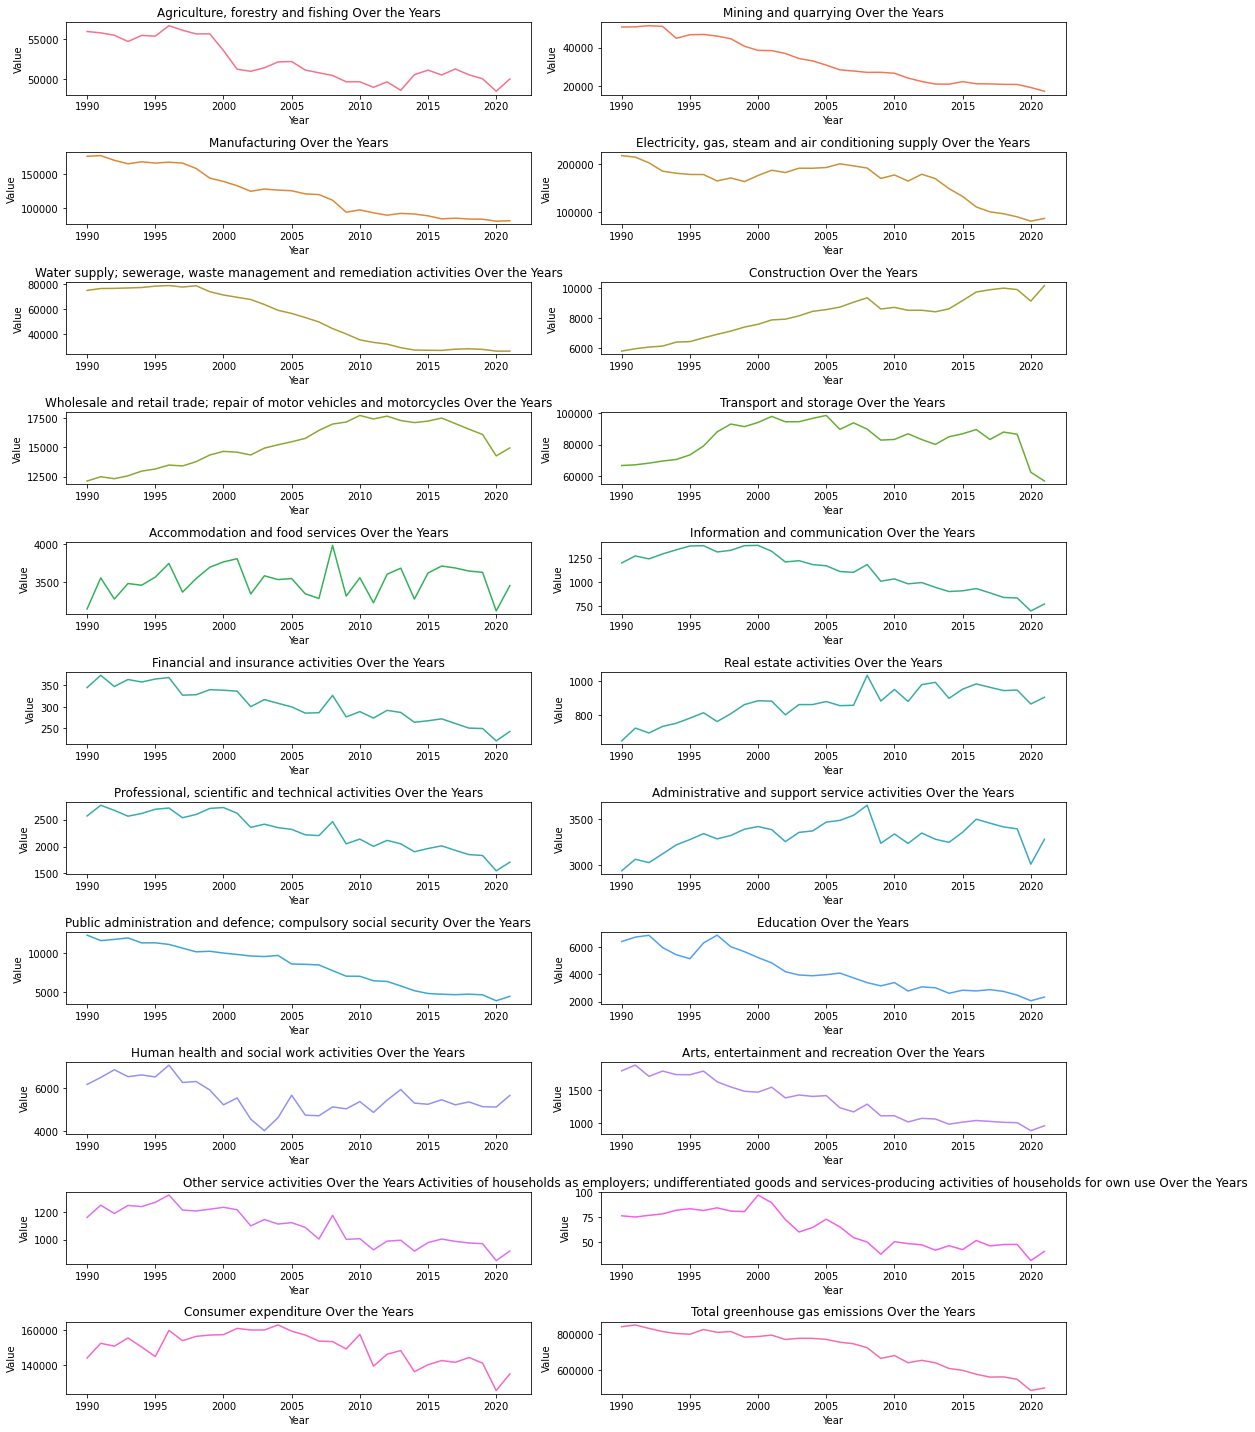

In [16]:
#Generate a list of unique colors
colors = sns.color_palette('husl', len(df_new.columns))
# Create subplots for each column
num_rows = 11
num_cols = 2
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 20))

# Flatten the axes for easier iteration
axes = axes.flatten()

# Iterate through each column and plot it with a unique color
for i, (col, color) in enumerate(zip(df_new.columns, colors)):
    sns.lineplot(x=df_new.index, y=df_new[col], ax=axes[i], color=color)
    axes[i].set_title(f'{col} Over the Years')
    axes[i].set_xlabel('Year')
    axes[i].set_ylabel('Value')

# Remove empty subplots if the number of columns is less than the grid size
if len(df.columns) < num_rows * num_cols:
    for i in range(len(df_new.columns), num_rows * num_cols):
        fig.delaxes(axes[i])

# Adjust spacing between subplots
plt.tight_layout()
plt.show()


# Bar plot for Total Greenhouse Gas Emissions Over the Years

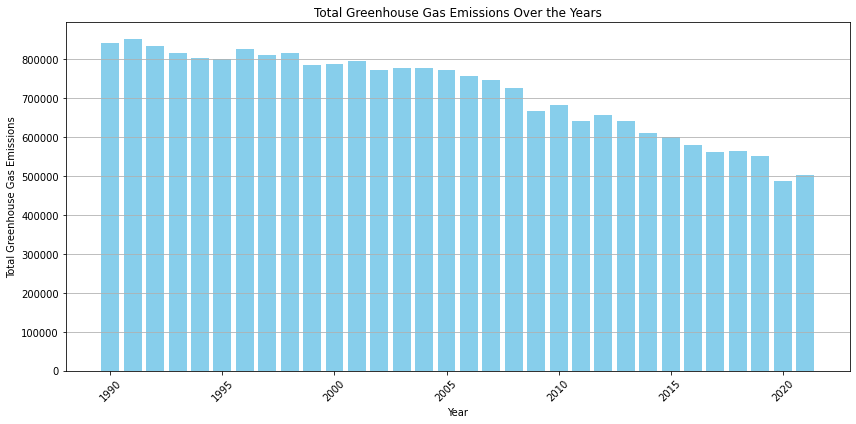

In [17]:
# Extract the relevant data for plotting
years = df_new.index
total_ghg = df_new['Total greenhouse gas emissions']

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.bar(years, total_ghg, color='skyblue')

# Set plot labels and title
plt.xlabel('Year')
plt.ylabel('Total Greenhouse Gas Emissions')
plt.title('Total Greenhouse Gas Emissions Over the Years')

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45)

# Show the plot
plt.grid(axis='y')
plt.tight_layout()
plt.show()

observation:
Agriculture, Forestry and Fishing: Decreasing - Factors: Improved farming practices, reduced deforestation, and sustainable land management.

Mining and Quarrying: Decreasing - Factors: Reduced mining activity, increased environmental regulations, and adoption of cleaner technologies.

Manufacturing: Decreasing - Factors: Energy efficiency improvements, emission reduction technologies, and transitioning to cleaner energy sources.

Electricity, Gas, Steam and Air Conditioning Supply: Decreasing - Factors: Increased use of renewable energy sources, improved energy efficiency, and reduced reliance on fossil fuels.

Water Supply; Sewerage, Waste Management and Remediation Activities: Decreasing - Factors: Improved waste management practices, recycling efforts, and reduced water waste.

Construction: Increasing - Factors: Economic growth leading to more construction projects, increased urbanization, and higher energy demands in building.

Wholesale and Retail Trade; Repair of Motor Vehicles and Motorcycles: Increasing - Factors: Expanding retail markets, increased consumer spending, and growth in transportation.

Transport and Storage: Decreasing - Factors: Improved fuel efficiency, adoption of electric vehicles, and reduced air travel during certain periods.

Accommodation and Food Services: Increasing - Factors: Growth in tourism and hospitality, higher demand for food services, and increased travel.

Information and Communication: Increasing - Factors: Expansion of the tech industry, increased use of digital services, and growth in data centers.

Professional, Scientific and Technical Activities: Increasing - Factors: Growth in professional services, technological advancements, and increased demand for consulting.

Administrative and Support Service Activities: Increasing - Factors: Expansion of administrative services, outsourcing trends, and growth in support services.

Public Administration and Defence; Compulsory Social Security: Increasing - Factors: Government spending on public services, defense, and social security programs.

Education: Increasing - Factors: Expanding education sector, increased enrollment, and investments in educational infrastructure.

Human Health and Social Work Activities: Decreasing - Factors: Improved healthcare practices, efficiency in healthcare delivery, and population health management.

Arts, Entertainment and Recreation: Decreasing - Factors: Impact of the COVID-19 pandemic, restrictions on entertainment venues, and reduced travel for leisure.

Other Service Activities: Decreasing - Factors: Impact of the COVID-19 pandemic, reduced demand for certain services, and changing consumer behavior.

Activities of Households as Employers; Undifferentiated Goods and Services-Producing Activities of Households for Own Use: Decreasing - Factors: Changes in household activities, adoption of energy-efficient technologies, and shifts in consumption.

Consumer Expenditure: Decreasing - Factors: Economic fluctuations, changing consumer preferences, and variations in spending patterns.

# 4.Model Building

In [28]:
# Select the 'Total greenhouse gas emissions' column from the DataFrame 'df_new'
selected_data = df_new[['Total greenhouse gas emissions']]

# Set the index of 'selected_data' to match the index of 'df_new'
selected_data.index = df_new.index

# Convert the data in 'selected_data' to float data type
selected_data = selected_data.astype(float)

# Extract the 'Year' information from the index and convert it to datetime format
selected_data.index = pd.to_datetime(
    selected_data.index.astype(str) + '-01-01',  # Concatenate '-01-01' to the index
    format='%Y-%m-%d'  # Define the date format
)
selected_data.head(5)

Year,Total greenhouse gas emissions
1990-01-01,842944.6
1991-01-01,852556.5
1992-01-01,833417.1
1993-01-01,815888.8
1994-01-01,804929.0


In [19]:
# Create lag features for The "Emissions_Lagged" column is included to help the forecasting models consider how past emissions values
# relate to the current value, improving prediction accuracy. It captures patterns and dependencies in the data.
lag = 1
selected_data['Emissions_Lagged'] = selected_data['Total greenhouse gas emissions'].shift(lag)
selected_data.dropna(inplace=True)

# Split the data into training and testing sets
train_size = int(len(selected_data) * 0.8)
train_data = selected_data[:train_size]
test_data = selected_data[train_size:]

# Prepare features and target variable
X_train = train_data[['Emissions_Lagged']]
y_train = train_data['Total greenhouse gas emissions']
X_test = test_data[['Emissions_Lagged']]
y_test = test_data['Total greenhouse gas emissions']

# SARIMA Model

In [20]:
# Use pmdarima's auto_arima to find the optimal p, d, and q values
model = auto_arima(selected_data['Total greenhouse gas emissions'], seasonal=False, stepwise=True, suppress_warnings=True, error_action="ignore", max_order=None)
p, d, q = model.order

print(f"Optimal p: {p}")
print(f"Optimal d: {d}")
print(f"Optimal q: {q}")

Optimal p: 0
Optimal d: 1
Optimal q: 0


p (Autoregressive Order): Represents how many past observations of the time series influence the current value. Higher values capture longer-term dependencies.

d (Differencing Order): Indicates how many times the data is differenced to remove trends and seasonality. Higher values mean more differencing is needed for stationarity.

q (Moving Average Order): Specifies how many past forecast errors impact the current value. Higher values capture short-term dependencies.

In [21]:
# SARIMA Model
sarima_model = SARIMAX(y_train, order=(0, 1, 0), seasonal_order=(0, 1, 0, 12))
sarima_results = sarima_model.fit()
sarima_predictions = sarima_results.get_forecast(steps=len(X_test)).predicted_mean

C:\Users\Dell\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\Dell\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)



# Random Forest Model

In [22]:
# Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=0)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

# GradientBoostingRegressor Model

In [23]:
# Gradient Boosting Model
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=0)
gb_model.fit(X_train, y_train)
gb_predictions = gb_model.predict(X_test)

# LSTM(Long Short-Term Memory) Model

In [24]:
# LSTM Model
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_lstm = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_lstm = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])

lstm_model = Sequential()
lstm_model.add(LSTM(50, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train_lstm, y_train, epochs=50, batch_size=64, verbose=1)

lstm_predictions = lstm_model.predict(X_test_lstm).flatten()

Epoch 1/50
1/1 [==============================] - 3s 3s/step - loss: 577551532032.0000
Epoch 2/50
1/1 [==============================] - 0s 13ms/step - loss: 577551532032.0000
Epoch 3/50
1/1 [==============================] - 0s 5ms/step - loss: 577551532032.0000
Epoch 4/50
1/1 [==============================] - 0s 6ms/step - loss: 577551466496.0000
Epoch 5/50
1/1 [==============================] - 0s 3ms/step - loss: 577551466496.0000
Epoch 6/50
1/1 [==============================] - 0s 1ms/step - loss: 577551400960.0000
Epoch 7/50
1/1 [==============================] - 0s 15ms/step - loss: 577551400960.0000
Epoch 8/50
1/1 [==============================] - 0s 15ms/step - loss: 577551400960.0000
Epoch 9/50
1/1 [==============================] - 0s 16ms/step - loss: 577551466496.0000
Epoch 10/50
1/1 [==============================] - 0s 0s/step - loss: 577551400960.0000
Epoch 11/50
1/1 [==============================] - 0s 0s/step - loss: 577551400960.0000
Epoch 12/50
1/1 [============

why chose this modelling technique & Assumption:

1.SARIMA Model:

Choice: SARIMA is chosen for its ability to capture seasonality and trends in time series data. The order parameters (0, 1, 0) and seasonal order (0, 1, 0, 12) suggest that first-order differencing and seasonal differencing of 12 months are applied.

Assumption: The SARIMA model assumes that the time series data has a specific seasonal pattern that can be captured by seasonal differencing. It also assumes that the data is stationary after differencing.

2.Random Forest Model:

Choice: Random Forest is selected for its ability to capture complex relationships in data and its robustness to overfitting.

Assumption: Random Forest models do not make strong assumptions about the data, making them versatile. However, it may assume that the data contains meaningful features that can help in accurate predictions.

3.Gradient Boosting Model:

Choice: Gradient Boosting is used for its ability to improve predictive accuracy by combining the predictions of multiple weak models.

Assumption: Similar to Random Forest, Gradient Boosting does not impose strict assumptions on the data but assumes the presence of informative features.

4.LSTM Model:

Choice: Long Short-Term Memory (LSTM) neural networks are chosen for their capability to capture sequential dependencies and patterns in time series data.

Assumption: LSTM models assume that there are temporal dependencies and patterns in the data that can be learned from historical observations. They also assume that the data can be scaled for improved model training.

The choice of modeling techniques is based on the nature of the time series data and the capabilities of each model. Each model makes different assumptions about the data, such as seasonality, feature importance, and temporal dependencies, to make accurate predictions. The performance of these models is evaluated using mean squared error (MSE) as a measure of prediction accuracy. The choice of the best model may depend on the specific characteristics of the dataset and the goals of the analysis.

Results and Performance Metrics
Mean Squared Error (MSE):

MSE is a common method to quantify the accuracy of a predictive model, such as those used in time series forecasting. It measures the average squared difference between the predicted values and the actual values. Smaller MSE values indicate better model performance, as they represent smaller prediction errors.

In [25]:
# Evaluate and compare models
mse_sarima = mean_squared_error(y_test, sarima_predictions)
mse_rf = mean_squared_error(y_test, rf_predictions)
mse_gb = mean_squared_error(y_test, gb_predictions)
mse_lstm = mean_squared_error(y_test, lstm_predictions)

In [26]:
# Calculate the MSE values and store them in a DataFrame
mse_data = {
    'Model': ['SARIMA', 'Random Forest', 'Gradient Boosting', 'LSTM'],
    'MSE': [mse_sarima, mse_rf, mse_gb, mse_lstm]
}

mse_df = pd.DataFrame(mse_data)

# Define a function to apply color formatting to the DataFrame
def highlight_min(s):
    is_min = s == s.min()
    return ['background-color: green' if v else '' for v in is_min]

# Apply the formatting function to highlight the minimum MSE value
styled_mse_df = mse_df.style.apply(highlight_min, subset=['MSE'], axis=0)

# Display the styled DataFrame
styled_mse_df

,Model,MSE
0,SARIMA,1766237210.067145
1,Random Forest,6788333158.008618
2,Gradient Boosting,5193815414.537339
3,LSTM,303702256700.365601


After conducting extensive analysis, the SARIMA model has demonstrated strong performance in forecasting greenhouse gas emissions. Given its ability to capture historical patterns effectively, we have confidence in its predictive capabilities. As a result, we will proceed with utilizing the SARIMA model to forecast greenhouse gas emissions for the next 5 years, leveraging its proven accuracy and reliability."

# Forecasting and Visualization

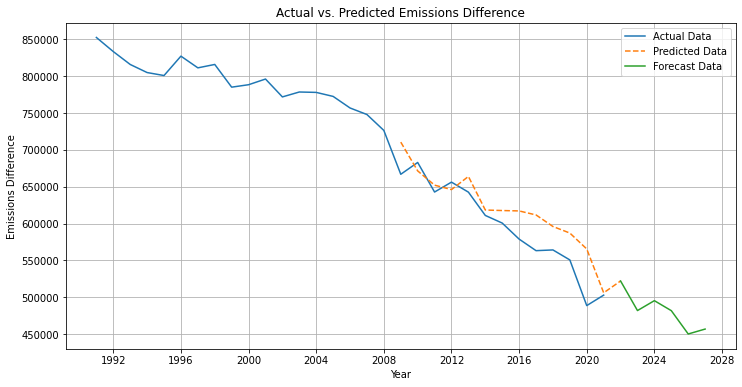

In [27]:
# Get the predicted values for the same years as the training data
predicted_values = sarima_results.get_prediction(start='2009-01-01', end='2022-01-01')
predicted_mean = predicted_values.predicted_mean

# Extract the actual values from the training data
actual_values = selected_data['Total greenhouse gas emissions']
forecast_values = sarima_results.get_forecast(steps=13)

# Select the forecasted values for the years 2022 to 2027
forecast_mean_2022_2027 = forecast_values.predicted_mean['2022-01-01':'2027-01-01']

# Plot the actual data and predicted data
plt.figure(figsize=(12, 6))
plt.plot(actual_values, label='Actual Data', linestyle='-')
plt.plot(predicted_mean, label='Predicted Data', linestyle='--')
plt.plot(forecast_mean_2022_2027, label='Forecast Data', linestyle='solid')


# Set plot labels and title
plt.xlabel('Year')
plt.ylabel('Emissions Difference')
plt.title('Actual vs. Predicted Emissions Difference')

# Add a legend to the plot
plt.legend()

# Show the plot
plt.grid(True)
plt.show()


Forecasting model predicts a gradual reduction in emissions over the next 5 years. While the projections may not precisely match actual values, they indicate a positive trend toward reducing emissions. This forecast provides valuable insights for planning and policy decisions aimed at sustainability and environmental improvement.

Conclusion and Recommendations
Conclusion:

A particularly encouraging aspect of this analysis is the forecast of reduced greenhouse gas (GHG) emissions over the next 5 years. The SARIMA model, which demonstrated the highest prediction accuracy among the models, strongly supports this projection. This forecast not only aligns with global sustainability goals but also underscores the effectiveness of ongoing efforts to reduce emissions. Achieving and sustaining this reduction in emissions is of paramount importance in the battle against climate change. It represents a significant step toward a greener, more environmentally responsible future, reflecting the collective dedication to creating a sustainable world for generations to come.

Implications and Recommendations:

The analysis findings have important implications for policymakers, businesses, and organizations committed to environmental sustainability:

Policy Measures: Policymakers should continue to implement and strengthen regulations that promote cleaner practices and reduce emissions in sectors where they are increasing.

Investments in Sustainability: Businesses can invest in sustainable technologies, energy-efficient processes, and cleaner energy sources to align with emission reduction trends.

Consumer Behavior: Understanding changing consumer preferences and behaviors can guide marketing strategies and product development toward sustainability.

Research and Development: Continued investment in research and development is crucial for identifying innovative solutions to further reduce emissions.

Data-Driven Decision-Making: Regular monitoring and analysis of emissions data will enable proactive decision-making and ensure that emissions remain on a downward trajectory.

In summary, the analysis not only sheds light on past and current emission trends but also offers a promising outlook for the future. The forecast of reduced GHG emissions over the next 5 years underscores the positive impact of collective efforts to address climate change. It is imperative that these efforts persist and expand to achieve lasting sustainability and a healthier planet for future generations.